In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
from torch.utils import data
from dataset import*
from config import settings
from torch.utils.tensorboard import SummaryWriter
from model import*
from train_test import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## load training data

In [6]:
transformers = {
        'year': MinMaxScaler(), # Normalize
        'weekday': None,
        'time': StandardScaler(), # Standardlize
        'weather': None
    }
df, transformers = load_data('train', total_sample=100000, random_sample=settings.totalN, scaling_transformers=transformers)

loaded csv file shape: (100000, 8)
setting time info...
setting geo info...
counting net fare...


In [4]:
df.describe()

,fare_amount,passenger_count,year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,...,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance,total_fixed_fees,net_fare
count,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,...,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000
mean,11.502957,1.681780,0.458728,0.138686,0.145949,0.149701,0.153074,0.153232,0.129880,0.129478,...,0.072126,0.075277,0.300675,0.300043,0.262527,0.264304,0.133576,0.133698,3.384269,8.118688
std,9.587967,1.299167,0.312047,0.345620,0.353056,0.356780,0.360060,0.360213,0.336173,0.335730,...,0.054969,0.052351,0.048959,0.044098,0.052672,0.052493,0.044353,0.042489,0.703426,9.504620
min,2.900000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000040,0.000174,0.000113,0.000097,0.003034,0.002908,0.001286,0.002362,2.500000,0.090000
25%,6.100000,1.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038789,0.042172,0.296465,0.295500,0.230474,0.232081,0.113489,0.113162,3.000000,2.700000
50%,8.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.065442,0.068002,0.305998,0.305911,0.257894,0.259348,0.130095,0.128898,3.500000,5.100000
75%,12.900000,2.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.092056,0.098002,0.317521,0.317463,0.284615,0.289131,0.156301,0.155191,3.500000,9.500000
max,165.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.520967,1.520967,1.773917,1.689596,1.713745,1.713745,1.599629,1.587101,21.300000,161.500000


In [7]:
df.columns

Index(['fare_amount', 'passenger_count', 'year', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'hour', 'is_holiday',
       'temperature', 'weathercode', 'distance', 'night', 'late_night',
       'from_JKF', 'to_JKF', 'from_LGA', 'to_LGA', 'to_EWR', 'from_Manhattan',
       'to_Manhattan', 'direction', 'latdiff', 'londiff', 'euclidean',
       'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance',
       'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance',
       'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance',
       'total_fixed_fees', 'net_fare'],
      dtype='object')

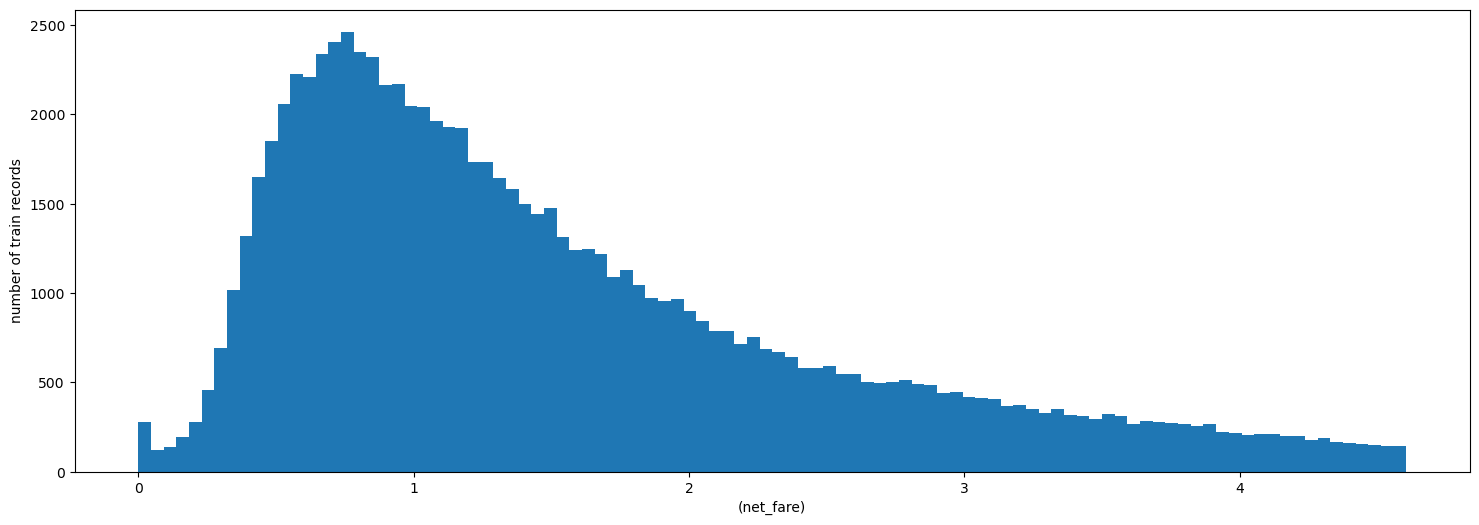

In [11]:
#Log-transformation
plt.subplots(figsize=(18,6))
plt.hist(df[df['distance'] < np.log(100)]['distance'].values, bins=100)
# plt.hist(np.log(df['net_fare'].values), bins=100)
plt.xlabel('(net_fare)')
plt.ylabel('number of train records')
plt.show()

In [8]:
print(df.shape)

(948, 24)


In [9]:
df.columns

Index(['fare_amount', 'passenger_count', 'year', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'hour', 'is_holiday',
       'temperature', 'weathercode', 'distance', 'from_JKF', 'to_JKF',
       'from_LGA', 'to_LGA', 'to_EWR', 'from_Manhattan', 'to_Manhattan',
       'total_fixed_fees', 'net_fare'],
      dtype='object')

## Training and validation data loader

In [4]:
BATCH_SIZE = 64
train_dataset = DataFolder(split='train', df=df, transformers=transformers)
train_dataloader = data.DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  drop_last=False,
                                  num_workers=4)

In [8]:
valid_dataset = DataFolder(split='valid', df=df, transformers=transformers)
valid_dataloader = data.DataLoader(dataset=valid_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  drop_last=False,
                                  num_workers=0)

## Mode select val or train

In [9]:
Mode_train = True

## Device

In [10]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


## Model select

In [11]:
model_name = 'FCNN32 with BN'
save_model_name = './model/'+ model_name +'.pth'
loss_filename = './loss curve/' + model_name + '.txt'

In [12]:
train_dataset.features

array([[2, 1.0, 0, ..., True, True, 4.3],
       [6, 0.8333333333333144, 0, ..., True, True, 3.0],
       [1, 0.5, 0, ..., True, True, 4.0],
       ...,
       [1, 0.8333333333333144, 0, ..., False, False, 3.0],
       [2, 0.16666666666668561, 0, ..., True, True, 3.5],
       [2, 0.8333333333333144, 0, ..., True, True, 4.0]], dtype=object)

In [13]:
input_dim = np.size(train_dataset.features, 1)
print(f'feature dimension = {input_dim}')
if Mode_train:
    model = FCNN(input_dim=input_dim).to(device) 
else:
    model = FCNN(input_dim=input_dim)
    model.load_state_dict(torch.load(save_model_name))
    model = model.to(device)
print(model)

feature dimension = 22
FCNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=22, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


## Loss function and optimizer

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0, momentum=0.9)

## Training epoch and stop condition

In [15]:
trained = False

In [16]:
writer = SummaryWriter('./logs/' + model_name)

In [17]:
if Mode_train:
    epochs = 50
    if not trained:
        loss_record = [1e6, 1e6, 1e6, 1e6, 1e6]
    for epoch in range(epochs):
        train_loss = train(train_dataloader, model, loss_fn, optimizer, writer=writer, record_batches=200)
        val_loss = val(valid_dataloader, model, loss_fn)
        writer.add_scalar("loss/training", train_loss, epoch+1)
        writer.add_scalar("loss/validation", val_loss, epoch+1)
        print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f}") 
        print(f'valid loss = {val_loss:.4f}')
        loss_record.append(train_loss)
        # if train_loss > sum(loss_record[-5:])/5*1.05 or train_loss < 0.1:
        #     print('Early stop!')
        #     break

    if not trained:        
        del loss_record[0:5]
    trained = True    
    print("Done!")

100%|██████████| 1/1 [00:00<00:00, 191.06it/s]


Epoch  1: Loss = 11.9661
valid loss = 3.1983


100%|██████████| 1/1 [00:00<00:00, 229.57it/s]


Epoch  2: Loss = 11.5079
valid loss = 3.1981


100%|██████████| 1/1 [00:00<00:00, 242.03it/s]


Epoch  3: Loss = 11.1683
valid loss = 3.0410


100%|██████████| 1/1 [00:00<00:00, 277.84it/s]


Epoch  4: Loss = 10.9401
valid loss = 2.7521


100%|██████████| 1/1 [00:00<00:00, 181.00it/s]


Epoch  5: Loss = 10.4193
valid loss = 2.8963


100%|██████████| 1/1 [00:00<00:00, 186.77it/s]


Epoch  6: Loss = 10.0205
valid loss = 1.3568


100%|██████████| 1/1 [00:00<00:00, 154.49it/s]


Epoch  7: Loss = 9.7166
valid loss = 2.5111


100%|██████████| 1/1 [00:00<00:00, 253.10it/s]


Epoch  8: Loss = 9.1850
valid loss = 2.0812


100%|██████████| 1/1 [00:00<00:00, 202.11it/s]


Epoch  9: Loss = 8.9204
valid loss = 0.0175


100%|██████████| 1/1 [00:00<00:00, 208.33it/s]


Epoch 10: Loss = 8.4189
valid loss = 0.1209


100%|██████████| 1/1 [00:00<00:00, 489.53it/s]


Epoch 11: Loss = 7.9406
valid loss = 2.3675


100%|██████████| 1/1 [00:00<00:00, 235.25it/s]


Epoch 12: Loss = 7.5836
valid loss = 0.6624


100%|██████████| 1/1 [00:00<00:00, 246.26it/s]


Epoch 13: Loss = 7.1559
valid loss = 2.2614


100%|██████████| 1/1 [00:00<00:00, 208.68it/s]


Epoch 14: Loss = 6.7626
valid loss = 0.2966


100%|██████████| 1/1 [00:00<00:00, 215.34it/s]


Epoch 15: Loss = 6.3165
valid loss = 0.3168


100%|██████████| 1/1 [00:00<00:00, 250.12it/s]


Epoch 16: Loss = 6.0809
valid loss = 0.6748


100%|██████████| 1/1 [00:00<00:00, 287.60it/s]


Epoch 17: Loss = 5.7745
valid loss = 2.1194


100%|██████████| 1/1 [00:00<00:00, 217.19it/s]


Epoch 18: Loss = 5.4298
valid loss = 4.6737


100%|██████████| 1/1 [00:00<00:00, 381.96it/s]


Epoch 19: Loss = 5.3996
valid loss = 0.6599


100%|██████████| 1/1 [00:00<00:00, 139.18it/s]


Epoch 20: Loss = 5.0561
valid loss = 4.9222


100%|██████████| 1/1 [00:00<00:00, 206.09it/s]


Epoch 21: Loss = 4.6822
valid loss = 4.9026


100%|██████████| 1/1 [00:00<00:00, 201.74it/s]


Epoch 22: Loss = 4.8822
valid loss = 5.0998


100%|██████████| 1/1 [00:00<00:00, 198.61it/s]


Epoch 23: Loss = 4.8671
valid loss = 6.9058


100%|██████████| 1/1 [00:00<00:00, 189.54it/s]


Epoch 24: Loss = 4.4061
valid loss = 1.0653


100%|██████████| 1/1 [00:00<00:00, 231.42it/s]


Epoch 25: Loss = 4.6006
valid loss = 7.7449


100%|██████████| 1/1 [00:00<00:00, 288.94it/s]


Epoch 26: Loss = 4.3869
valid loss = 3.1365


100%|██████████| 1/1 [00:00<00:00, 205.90it/s]


Epoch 27: Loss = 4.3956
valid loss = 0.3095


100%|██████████| 1/1 [00:00<00:00, 201.98it/s]


Epoch 28: Loss = 4.2911
valid loss = 4.2274


100%|██████████| 1/1 [00:00<00:00, 202.47it/s]


Epoch 29: Loss = 4.1930
valid loss = 1.6217


100%|██████████| 1/1 [00:00<00:00, 240.72it/s]


Epoch 30: Loss = 4.1059
valid loss = 4.1913


100%|██████████| 1/1 [00:00<00:00, 203.29it/s]


Epoch 31: Loss = 4.2673
valid loss = 5.5112


100%|██████████| 1/1 [00:00<00:00, 173.19it/s]


Epoch 32: Loss = 3.8892
valid loss = 8.0134


100%|██████████| 1/1 [00:00<00:00, 172.78it/s]


Epoch 33: Loss = 4.1496
valid loss = 4.0087


100%|██████████| 1/1 [00:00<00:00, 199.11it/s]


Epoch 34: Loss = 3.9630
valid loss = 2.5795


100%|██████████| 1/1 [00:00<00:00, 225.22it/s]


Epoch 35: Loss = 4.1199
valid loss = 6.8732


100%|██████████| 1/1 [00:00<00:00, 213.26it/s]


Epoch 36: Loss = 3.9112
valid loss = 4.5251


100%|██████████| 1/1 [00:00<00:00, 202.26it/s]


Epoch 37: Loss = 3.8609
valid loss = 7.5425


100%|██████████| 1/1 [00:00<00:00, 206.22it/s]


Epoch 38: Loss = 3.9798
valid loss = 6.5976


100%|██████████| 1/1 [00:00<00:00, 224.07it/s]


Epoch 39: Loss = 3.8369
valid loss = 5.0752


100%|██████████| 1/1 [00:00<00:00, 322.56it/s]


Epoch 40: Loss = 3.7435
valid loss = 3.9235


100%|██████████| 1/1 [00:00<00:00, 197.05it/s]


Epoch 41: Loss = 3.9010
valid loss = 5.8975


100%|██████████| 1/1 [00:00<00:00, 311.33it/s]


Epoch 42: Loss = 4.2160
valid loss = 5.6996


100%|██████████| 1/1 [00:00<00:00, 197.31it/s]


Epoch 43: Loss = 3.6385
valid loss = 5.1953


100%|██████████| 1/1 [00:00<00:00, 292.65it/s]


Epoch 44: Loss = 3.5720
valid loss = 3.3609


100%|██████████| 1/1 [00:00<00:00, 182.99it/s]


Epoch 45: Loss = 3.5386
valid loss = 6.4019


100%|██████████| 1/1 [00:00<00:00, 242.01it/s]


Epoch 46: Loss = 3.7894
valid loss = 8.3511


100%|██████████| 1/1 [00:00<00:00, 237.48it/s]


Epoch 47: Loss = 4.0173
valid loss = 9.3291


100%|██████████| 1/1 [00:00<00:00, 164.75it/s]


Epoch 48: Loss = 3.9629
valid loss = 5.0825


100%|██████████| 1/1 [00:00<00:00, 222.23it/s]


Epoch 49: Loss = 3.8099
valid loss = 4.4950


100%|██████████| 1/1 [00:00<00:00, 455.61it/s]

Epoch 50: Loss = 3.5704
valid loss = 4.9826
Done!


## Plot training loss curve

In [18]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    plt.plot(loss_list)
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

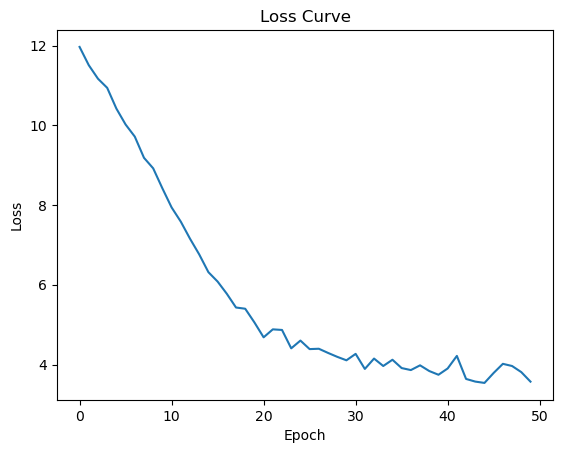

In [19]:
if Mode_train:
    plot_loss_curve(loss_record)
else:
    print('Auto load loss curve')
    with open(loss_filename) as fh:
        s = fh.readline()
        L = s[1:-1].split(', ')
        loss_record = [float(x) for x in L]        
    plot_loss_curve(loss_record)

## Evaluate

In [21]:
#final_train_loss = val(train_dataloader, model, loss_fn)
final_val_loss = val(valid_dataloader, model, loss_fn)
print(f'final valid loss = {final_val_loss:.4f}')

100%|██████████| 1/1 [00:00<00:00, 587.19it/s]

final valid loss = 4.9826


In [22]:
print(f'final valid loss = {final_val_loss:.4f}')

final valid loss = 4.9826


## Save model

In [ ]:
if Mode_train:
    torch.save(model.state_dict(), save_model_name)
    with open(loss_filename, 'w') as fh:
        fh.writelines(str(loss_record))   

## Output test result

In [22]:
BATCH_SIZE = 64
test_dataset = DataFolder(split='test', transformers=transformers)
test_dataloader = data.DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  drop_last=False,
                                  num_workers=0)

loaded test csv file shape: (9914, 7)
setting time info...
setting geo info...
counting fixed fee...


In [23]:
df_test = pd.DataFrame(test_dataset.key_list, columns=["key"])

In [24]:
df_test

,key
0,2015-01-27 13:08:24.0000002
1,2015-01-27 13:08:24.0000003
2,2011-10-08 11:53:44.0000002
3,2012-12-01 21:12:12.0000002
4,2012-12-01 21:12:12.0000003
...,...
9909,2015-05-10 12:37:51.0000002
9910,2015-01-12 17:05:51.0000001
9911,2015-04-19 20:44:15.0000001
9912,2015-01-31 01:05:19.0000005


In [25]:
test_dataset.df

,key,passenger_count,year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,...,distance,from_JKF,to_JKF,from_LGA,to_LGA,to_EWR,from_Manhattan,to_Manhattan,direction,total_fixed_fees
0,2015-01-27 13:08:24.0000002,1,1.000000,1,0,0,0,0,0,0,...,1.443607,False,False,False,False,False,True,True,-162.897409,3.3
1,2015-01-27 13:08:24.0000003,1,1.000000,1,0,0,0,0,0,0,...,1.507044,False,False,False,False,False,False,True,-24.688387,3.3
2,2011-10-08 11:53:44.0000002,1,0.333333,0,0,0,0,1,0,0,...,0.384398,False,False,False,False,False,True,True,156.994148,3.0
3,2012-12-01 21:12:12.0000002,1,0.500000,0,0,0,0,1,0,0,...,1.218529,False,False,False,False,False,True,True,-156.486692,3.5
4,2012-12-01 21:12:12.0000003,1,0.500000,0,0,0,0,1,0,0,...,3.347514,False,False,False,False,False,True,True,-159.381549,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,6,1.000000,0,0,0,0,0,1,0,...,1.320336,False,False,False,False,False,True,True,150.357203,3.3
9910,2015-01-12 17:05:51.0000001,6,1.000000,0,0,0,0,0,0,1,...,2.032486,False,False,False,False,False,True,True,-157.761247,4.3
9911,2015-04-19 20:44:15.0000001,6,1.000000,0,0,0,0,0,1,0,...,11.920349,False,True,False,False,False,True,False,117.409509,3.8
9912,2015-01-31 01:05:19.0000005,6,1.000000,0,0,0,0,1,0,0,...,5.184402,False,False,False,True,False,True,True,27.907235,3.8


In [26]:
test_dataset.df.describe()

,passenger_count,year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,hour,is_holiday,temperature,weathercode,distance,direction,total_fixed_fees
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,1.671273,0.469303,0.170668,0.162598,0.118620,0.129413,0.148780,0.123260,0.146661,-0.004255,0.280916,12.900978,9.147065,2.134640,-15.050413,3.421192
std,1.278747,0.300558,0.376237,0.369017,0.323357,0.335673,0.355889,0.328752,0.353786,1.055503,0.449469,9.928859,20.238913,2.468319,104.581807,0.675622
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.073809,0.000000,-19.100000,0.000000,0.000000,-179.916210,2.500000
25%,1.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.844440,0.000000,5.500000,0.000000,0.806712,-126.132654,3.000000
50%,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.231258,0.000000,13.900000,1.000000,1.377836,8.977282,3.500000
75%,2.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.845943,1.000000,20.600000,3.000000,2.513634,52.665549,3.500000
max,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.460628,1.000000,38.300000,75.000000,62.134660,179.944850,21.000000


In [29]:
predictions = test(test_dataloader, model)
df_test["fare_amount"] = predictions
df_test["fare_amount"] = df_test["fare_amount"]+test_dataset.df["total_fixed_fees"]

# 將dataframe保存為CSV文件
df_test.to_csv("predictions.csv", index=False)

100%|██████████| 155/155 [00:00<00:00, 1741.36it/s]
